# What kind of scoring performances exist in the NBA?

We will try to characterise the scoring performances that appear in the NBA in this analysis.

This analysis could be useful for the following reasons:
- Grouping players by their scoring performances
- Identifying which teams (do not) lean on high-scoring players/stars
    - And what kind of teams are successful
    - How players perform from with different teams

In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from os import environ
from os.path import expanduser, join as ptjoin
import plotly.express as px

In [2]:
spark = SparkSession.builder.appName('box_score_analysis').master('local[*]').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/10/15 10:30:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
f_path = ptjoin(expanduser('~/spark_apps'),'pbp_outputs')

df = spark.read.parquet(f_path)

23/10/15 10:30:40 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [4]:
game_df = df.select('game')#.printSchema()

In [5]:
game_df.select('game.*').show()

+--------------------+----------+--------------------+----------+--------------------+--------------------+--------------------+--------+-----------+---------------+--------------------+----------+--------------------+----------+--------------+-----------+--------------------+----------------+--------------------+----------+--------------------+------------+----------+-----------+--------------------+--------------------+--------------------+------+--------------------+--------------------+-----------+--------------+-------+----------------+---------------+------------------+--------+
|               arena|attendance|            awayTeam|awayTeamId|     awayTeamPlayers|           branchUrl|        broadcasters|duration|  gameClock|       gameCode|              gameEt|    gameId|           gameRecap|gameStatus|gameStatusText|gameSubtype|         gameTimeUTC|historicalStatus|            homeTeam|homeTeamId|     homeTeamPlayers|hustleStatus|hyperlinks|ifNecessary|    lastFiveMeetings|    

In [6]:
away_team = game_df.select('game.gameTimeUTC','game.gameId','game.awayTeam.players','game.awayTeamId').withColumnRenamed('awayTeamId','teamId')
home_team = game_df.select('game.gameTimeUTC','game.gameId','game.homeTeam.players','game.homeTeamId').withColumnRenamed('homeTeamId','teamId')

In [7]:
box_scores = away_team.union(home_team)

In [9]:
box_scores = box_scores.select('gameTimeUTC','gameId','teamId',F.explode('players').alias('player_stats'))

In [10]:
box_scores = box_scores.select('gameTimeUTC','gameId','teamId','player_stats.*')

In [11]:
box_scores = box_scores.select(*box_scores.columns[:-1],'statistics.*')#.show()

+--------------------+----------+----------+--------------------+-----------+---------+---------+----+--------------+--------+-----------------+--------+-------+------+-------------------+--------------+--------------------+-------------+-------------------+--------------+--------------------+-------+---------------+------+-----------------+-----------------+-------------+------+----------------------+-----------------+-----------------------+---------+--------------+--------------------+--------------------+--------------------+--------------------+-----------------------+---------------------+
|         gameTimeUTC|    gameId|    teamId|             comment| familyName|firstName|jerseyNum|name|         nameI|personId|       playerSlug|position|assists|blocks|fieldGoalsAttempted|fieldGoalsMade|fieldGoalsPercentage|foulsPersonal|freeThrowsAttempted|freeThrowsMade|freeThrowsPercentage|minutes|plusMinusPoints|points|reboundsDefensive|reboundsOffensive|reboundsTotal|steals|threePointersAt

In [12]:
value = {"points":1,"blocks":4,"assists":2,"turnovers":-2,
         "fieldGoalsMade":2,"fieldGoalsAttempted":-1,
         "freeThrowsMade":1,"freeThrowsAttempted":-1,
         "threePointersMade":1,"steals":4,"reboundsTotal":1}


In [13]:
box_scores = box_scores.withColumn('fantasy_points',box_scores['points']*value['points'] +
                                   box_scores['blocks']*value['blocks'] +
                                   box_scores['assists']*value['assists'] +
                                   box_scores['turnovers']*value['turnovers'] +
                                   box_scores['fieldGoalsMade']*value['fieldGoalsMade'] +
                                   box_scores['fieldGoalsAttempted']*value['fieldGoalsAttempted'] +
                                   box_scores['freeThrowsMade']*value['freeThrowsMade'] +
                                   box_scores['freeThrowsAttempted']*value['freeThrowsAttempted'] +
                                   box_scores['threePointersMade']*value['threePointersMade'] +
                                   box_scores['steals']*value['steals'] +
                                   box_scores['reboundsTotal']*value['reboundsTotal']
                                   )

In [14]:
box_scores = box_scores.na.fill(0)

In [15]:
import matplotlib.pyplot as plt

def plot_fp_distribution(fps,centres = None, labels = None):
    fig = plt.figure(figsize=(15,2))
    ax = fig.add_axes([0,1,1,1])

    plt.vlines(x = fps, ymin = -0.01,ymax=0.01, colors='b',label='player averages')
    plt.vlines(x = centres.mean_fp, ymin = -0.1,ymax=0.1, colors='r',linestyles='dashed',label='cluster centres')
    plt.vlines(x = centres.median_fp, ymin = -0.1,ymax=0.1, colors='g',linestyles='dashed',label='cluster centres')
    plt.ylim((-0.05,0.05))
    plt.xlim((0,fps.fantasy_points.max()+15))
    plt.xlabel("Average Fantasy Points")
    # plt.legend()
    plt.xticks(range(-5,70,5))
    mod = -1
    for c,l in zip(centres.itertuples(),labels):
        plt.annotate(l,(c.mean_fp,0.04*mod))
        mod *= -1
    
    return

Transformation stage

In [16]:
start = box_scores.columns.index('assists')
end = -1

In [17]:
to_scale = box_scores.columns[start:end]

In [18]:
to_scale = [i for i in to_scale if 'minutes' not in i]

In [19]:
from pyspark.ml.feature import MinMaxScaler, VectorAssembler

scale_assembler = VectorAssembler(inputCols=to_scale,outputCol='to_scale_features')
box_scores = scale_assembler.transform(box_scores)

# keep_assembler = VectorAssembler(inputCols=keep,outputCol='unscaled_features')
# box_scores = keep_assembler.transform(box_scores)

In [20]:
box_scores.show()

+--------------------+----------+----------+--------------------+-----------+---------+---------+----+--------------+--------+-----------------+--------+-------+------+-------------------+--------------+--------------------+-------------+-------------------+--------------+--------------------+-------+---------------+------+-----------------+-----------------+-------------+------+----------------------+-----------------+-----------------------+---------+--------------+--------------------+
|         gameTimeUTC|    gameId|    teamId|             comment| familyName|firstName|jerseyNum|name|         nameI|personId|       playerSlug|position|assists|blocks|fieldGoalsAttempted|fieldGoalsMade|fieldGoalsPercentage|foulsPersonal|freeThrowsAttempted|freeThrowsMade|freeThrowsPercentage|minutes|plusMinusPoints|points|reboundsDefensive|reboundsOffensive|reboundsTotal|steals|threePointersAttempted|threePointersMade|threePointersPercentage|turnovers|fantasy_points|   to_scale_features|
+-----------

In [21]:
mm_scaler = MinMaxScaler(inputCol= 'to_scale_features', outputCol='scaled_features')
scaler = mm_scaler.fit(box_scores)

box_scores = scaler.transform(box_scores)

Let's use PCA to perform dimensionality reduction and examine which number of components explain a reasonable amount of the variance.

There are 15 features at the moment. Let's try reducing to 10 principal components.

In [22]:
len(to_scale)

19

In [23]:
from pyspark.ml.feature import PCA

pca = PCA(k=10,inputCol='scaled_features', outputCol='pc')
pca_model = pca.fit(box_scores)

23/10/15 10:31:10 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/10/15 10:31:10 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
23/10/15 10:31:10 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


23/10/15 10:31:13 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/10/15 10:31:13 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [24]:
box_scores = pca_model.transform(box_scores)

Lets examine the explained variance and make a decision on how many components are sufficient for our purposes. This means that we will make a cutoff where there are no longer any useful incremental gains in explained variance.

In [25]:
import pandas as pd

explained_variance = pd.DataFrame([0]+list(100*pca_model.explainedVariance),columns = ['exp_var'])
explained_variance.iloc[1:,] # show the explained variance in order

,exp_var
1,50.350883
2,18.709816
3,10.874763
4,6.125378
5,2.866341
6,1.861777
7,1.642564
8,1.450338
9,1.300893
10,1.134489


In [26]:
explained_variance['cumulative_var_exp'] = explained_variance['exp_var'].cumsum(0)

<Axes: xlabel='Number of components', ylabel='Explained variance / %'>

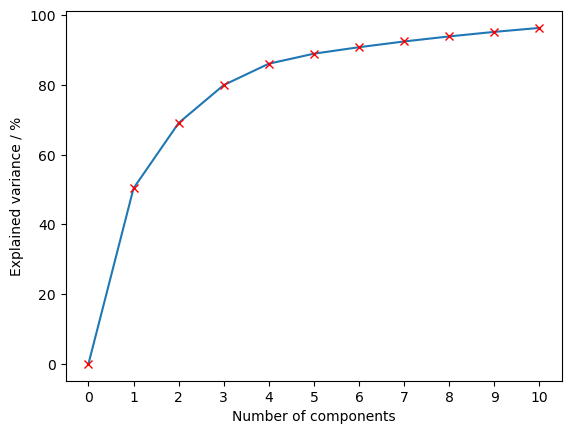

In [27]:
explained_variance.plot(kind='line',y = 'cumulative_var_exp',
xlabel='Number of components',ylabel='Explained variance / %',
legend=False,xticks=range(0,11),marker = 'x',mec='r')

It appears that the 6 principal components are sufficient to explain the variance in the data. Lets see exactly how much of the variance is explained by 6 principal components.

In [28]:
explained_variance['cumulative_var_exp'].iloc[6]#.sum()

90.7889576365236

6 components explain 97% of the variance. We can therefore reduce the input features by more than half: from 15 to 6.

In [29]:
from pyspark.ml.feature import VectorSlicer
slicer = VectorSlicer(inputCol='pc',outputCol='cluster_cols',indices=list(range(6)))

In [30]:
box_scores = slicer.transform(box_scores)

## Cluster analysis

With the features now ready, It is now possible to perform clustering. Let's use K-Means with $2 <= k<= 20$ and select the best model with the elbow method after plotting the intracluster distance (or training cost) with respect to k.

In [31]:
from pyspark.ml.clustering import KMeans, GaussianMixture

In [32]:
from pyspark.sql.window import Window

Fitting the models

In [33]:
errors = []
seed = 42

In [34]:
scale_assembler = VectorAssembler(inputCols=['fantasy_points'],outputCol='to_scale_fantasy_points')
box_scores = scale_assembler.transform(box_scores)
mm_scaler = MinMaxScaler(inputCol= 'to_scale_fantasy_points', outputCol='scaled_fantasy_points')
scaler = mm_scaler.fit(box_scores)
box_scores = scaler.transform(box_scores)
gm = GaussianMixture(featuresCol='scaled_fantasy_points', k=5,seed=seed)

In [35]:
model = gm.fit(box_scores)

23/10/15 10:31:26 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/10/15 10:31:26 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [36]:
preds_gm = model.transform(box_scores)

In [37]:
preds_gm.show()

+--------------------+----------+----------+--------------------+-----------+---------+---------+----+--------------+--------+-----------------+--------+-------+------+-------------------+--------------+--------------------+-------------+-------------------+--------------+--------------------+-------+---------------+------+-----------------+-----------------+-------------+------+----------------------+-----------------+-----------------------+---------+--------------+--------------------+--------------------+--------------------+--------------------+-----------------------+---------------------+--------------------+----------+
|         gameTimeUTC|    gameId|    teamId|             comment| familyName|firstName|jerseyNum|name|         nameI|personId|       playerSlug|position|assists|blocks|fieldGoalsAttempted|fieldGoalsMade|fieldGoalsPercentage|foulsPersonal|freeThrowsAttempted|freeThrowsMade|freeThrowsPercentage|minutes|plusMinusPoints|points|reboundsDefensive|reboundsOffensive|rebo

In [38]:
preds_gm = preds_gm.withColumn('game_date',F.to_timestamp(F.col('gameTimeUTC')))

In [39]:
player_window = Window.partitionBy('personId').orderBy('game_date').rowsBetween(-4,0)

In [40]:
preds_gm = preds_gm.withColumn('rolling_fp_mean', F.mean(F.col('fantasy_points')).over(player_window))

In [94]:
preds_gm = preds_gm.withColumn('year', F.year(preds_gm.game_date)).filter('year > 2017')

In [95]:
preds_gm.filter('nameI = "M. Jordan"').show()

+-----------+------+------+-------+----------+---------+---------+----+-----+--------+----------+--------+-------+------+-------------------+--------------+--------------------+-------------+-------------------+--------------+--------------------+-------+---------------+------+-----------------+-----------------+-------------+------+----------------------+-----------------+-----------------------+---------+--------------+-----------------+---------------+---+------------+-----------------------+---------------------+-----------+----------+---------+---------------+----+------+------------+----------------+
|gameTimeUTC|gameId|teamId|comment|familyName|firstName|jerseyNum|name|nameI|personId|playerSlug|position|assists|blocks|fieldGoalsAttempted|fieldGoalsMade|fieldGoalsPercentage|foulsPersonal|freeThrowsAttempted|freeThrowsMade|freeThrowsPercentage|minutes|plusMinusPoints|points|reboundsDefensive|reboundsOffensive|reboundsTotal|steals|threePointersAttempted|threePointersMade|threePoint

In [96]:
preds_gm = preds_gm.withColumn('season', F.substring(F.col('gameId'),1,5))

In [97]:
preds_gm.withColumn('season_type',F.substring(F.col('season'),1,3)).select('season_type').distinct().show()

+-----------+
|season_type|
+-----------+
|        005|
|        001|
|        004|
|        002|
|        003|
+-----------+



In [98]:
preds_gm = preds_gm.withColumn('season_label',
                   F.when(F.substring(preds_gm.season,1,3) == '001', 'preseason').when(F.substring(preds_gm.season,1,3) == '002', 'regular season').
                   when(F.substring(preds_gm.season,1,3) == '003', 'all star').when(F.substring(preds_gm.season,1,3) == '004', 'post season').otherwise('unknown'))

In [99]:
preds_gm = (preds_gm.withColumn('prediction_label',
                   F.when(preds_gm.prediction == 1, '1. Outstanding').when(preds_gm.prediction == 0, '2. Good').
                   when(preds_gm.prediction == 2, '3. average').otherwise('4. avoid'))
                   )

In [180]:
players = (preds_gm.groupBy('season','season_label','personId','nameI','playerSlug','prediction','prediction_label')
           .agg(F.count('personId').alias('count'),F.mean('fantasy_points').alias('fantasy_points'),F.min('year').alias('start'),F.max('year').alias('end'))
           .orderBy(['count','fantasy_points','personId'], ascending = [False,False, True])
           )

In [181]:
pw = Window.partitionBy(['season','personId'])

In [182]:
players = players.withColumn('total_count',F.sum(F.col('count')).over(pw)).withColumn('percentage',100*F.col('count')/F.col('total_count'))#.show()

In [183]:
# players = (players.withColumn('prediction_label',
#                    F.when(players.prediction == 1, '1. Outstanding').when(players.prediction == 0, '2. Good').
#                    when(players.prediction == 2, '3. average').otherwise('4. avoid'))
#                    )

In [184]:
game_counts = preds_gm.groupBy(['season','teamId']).agg(F.countDistinct('gameId').alias('games'))

In [185]:
game_counts = game_counts.groupBy('season').agg(F.max('games').alias('season_games'))

In [186]:
players = players.join(game_counts,'season')

In [187]:
fantasy_df = players.filter('season_label in ("regular season","postseason")').withColumn('attendance', players.total_count/players.season_games)

In [188]:
fantasy_df.orderBy(['prediction_label','count','attendance','percentage'], ascending = [True, False, False, False]).show()

+------+--------------+--------+--------------------+--------------------+----------+----------------+-----+-----------------+-----+----+-----------+------------------+------------+------------------+
|season|  season_label|personId|               nameI|          playerSlug|prediction|prediction_label|count|   fantasy_points|start| end|total_count|        percentage|season_games|        attendance|
+------+--------------+--------+--------------------+--------------------+----------+----------------+-----+-----------------+-----+----+-----------+------------------+------------+------------------+
| 00222|regular season|  203999|            N. Jokic|        nikola-jokic|         1|  1. Outstanding|   38|71.15789473684211| 2022|2023|         69|55.072463768115945|          82|0.8414634146341463|
| 00220|regular season|  203999|            N. Jokic|        nikola-jokic|         1|  1. Outstanding|   37|71.32432432432432| 2020|2021|         72|51.388888888888886|          72|               

In [189]:
decrease = 0.01
diminishing_returns = 1 - decrease
current_year = 2023
fantasy_df.withColumn('adjusted_total_count', F.col('total_count')* diminishing_returns* 1/(current_year - F.col('start'))).filter('nameI = "J. Harden"').show()

+------+--------------+--------+---------+------------+----------+----------------+-----+-----------------+-----+----+-----------+------------------+------------+------------------+--------------------+
|season|  season_label|personId|    nameI|  playerSlug|prediction|prediction_label|count|   fantasy_points|start| end|total_count|        percentage|season_games|        attendance|adjusted_total_count|
+------+--------------+--------+---------+------------+----------+----------------+-----+-----------------+-----+----+-----------+------------------+------------+------------------+--------------------+
| 00220|regular season|  201935|J. Harden|james-harden|         1|  1. Outstanding|   21|69.66666666666667| 2020|2021|         48|             43.75|          72|0.6666666666666666|  15.839999999999998|
| 00220|regular season|  201935|J. Harden|james-harden|         0|         2. Good|   19|44.68421052631579| 2021|2021|         48|39.583333333333336|          72|0.6666666666666666|  23.75

In [152]:
fantasy_df.show()

+------+--------------+--------+-----------+----------+----------------+-----+------------------+-----+----+-----------+------------------+------------+------------------+
|season|  season_label|personId|      nameI|prediction|prediction_label|count|    fantasy_points|start| end|total_count|        percentage|season_games|        attendance|
+------+--------------+--------+-----------+----------+----------------+-----+------------------+-----+----+-----------+------------------+------------+------------------+
| 00220|regular season|    2544|   L. James|         0|         2. Good|   29|45.793103448275865| 2020|2021|         45| 64.44444444444444|          72|             0.625|
| 00220|regular season|    2544|   L. James|         1|  1. Outstanding|   10|              69.4| 2020|2021|         45| 22.22222222222222|          72|             0.625|
| 00220|regular season|    2544|   L. James|         2|      3. average|    6|25.666666666666668| 2020|2021|         45|13.333333333333334| 

In [190]:
expected = (fantasy_df.groupBy('personId','nameI','playerSlug','prediction_label')
            .agg(F.sum('count').alias('performance_count'),
                 F.sum('total_count').alias('games_played'),
                 F.sum('season_games').alias('total_games'))
            .withColumn('percentage_played',F.col('games_played')/F.col('total_games'))
            .withColumn('percentage_performance',F.col('performance_count')/F.col('games_played'))
            )

In [191]:
expected = expected.withColumn('expected_games', F.col('percentage_played')*82).withColumn('expected_performances', F.round(F.col('expected_games')*F.col('percentage_performance')))

In [192]:
mean_fps  = preds_gm.groupBy('prediction_label').agg(F.mean('fantasy_points').alias('group_mean_fantasy_points'))

In [193]:
expected = expected.join(mean_fps,'prediction_label')

In [194]:
expected.show()

+----------------+--------+------------------+--------------------+-----------------+------------+-----------+-------------------+----------------------+------------------+---------------------+-------------------------+
|prediction_label|personId|             nameI|          playerSlug|performance_count|games_played|total_games|  percentage_played|percentage_performance|    expected_games|expected_performances|group_mean_fantasy_points|
+----------------+--------+------------------+--------------------+-----------------+------------+-----------+-------------------+----------------------+------------------+---------------------+-------------------------+
|         2. Good|  201587|          N. Batum|       nicolas-batum|               30|         148|        154|  0.961038961038961|   0.20270270270270271|  78.8051948051948|                 16.0|        39.88258164852255|
|  1. Outstanding|  202355|      H. Whiteside|    hassan-whiteside|                1|          54|         72|      

In [195]:
expected = expected.withColumn('expected_points', F.col('expected_performances')*F.col('group_mean_fantasy_points'))#.show()

In [176]:
preds_gm.select('personId').distinct().count()

873

In [197]:
# expected = expected.withColumn('adjusted_expected_fps', F.col('expected_points') * diminishing_returns/(current_year- F.col('start')))

In [121]:
positions = box_scores.select('personId','position').filter('position != ""')
positions.groupBy('personId','position').count().show()

+--------+--------+-----+
|personId|position|count|
+--------+--------+-----+
|     420|       F|   41|
|    1729|       F|   88|
|  203460|       F|   91|
|  204001|       C|   76|
| 1629628|       F|   88|
|     761|       C|  113|
|  201162|       F|  125|
|  202343|       G|    5|
| 1627783|       F|  248|
|  202697|       F|   61|
|     185|       F|  671|
|    2399|       F|  391|
|    2557|       G|  251|
|    1542|       C|   77|
|  203114|       G|   92|
|  204456|       G|   67|
|    1886|       F|   26|
| 1626220|       F|  131|
| 1628971|       G|   73|
|    1501|       F|  392|
+--------+--------+-----+
only showing top 20 rows



In [117]:
positions.groupBy('personId','position').count().orderBy('personId', ascending = True).show()

+--------+--------+-----+
|personId|position|count|
+--------+--------+-----+
|       2|       G|    8|
|       3|       C|    3|
|       3|       F|  145|
|       7|       C|   42|
|      15|       F|   11|
|      15|       G|  227|
|      17|       G|  152|
|      17|       F|    1|
|      21|       G|   85|
|      22|       C|  298|
|      23|       C|   19|
|      23|       F|  147|
|      26|       C|  272|
|      28|       F|    4|
|      28|       G|   83|
|      29|       C|  210|
|      31|       C|    6|
|      32|       C|   28|
|      32|       F|    1|
|      35|       C|   25|
+--------+--------+-----+
only showing top 20 rows



In [234]:
expected.filter('nameI = "K. Leonard"').show(5)

+----------------+--------+----------+-------------+-----------------+------------+-----------+------------------+----------------------+-----------------+---------------------+-------------------------+------------------+
|prediction_label|personId|     nameI|   playerSlug|performance_count|games_played|total_games| percentage_played|percentage_performance|   expected_games|expected_performances|group_mean_fantasy_points|   expected_points|
+----------------+--------+----------+-------------+-----------------+------------+-----------+------------------+----------------------+-----------------+---------------------+-------------------------+------------------+
|         2. Good|  202695|K. Leonard|kawhi-leonard|               64|         110|        154|0.7142857142857143|    0.5818181818181818|58.57142857142857|                 34.0|        39.88258164852255|1356.0077760497668|
|        4. avoid|  202695|K. Leonard|kawhi-leonard|                6|          58|         72|0.80555555555

In [ ]:
expected

In [235]:
pd_df = (expected.groupBy(['personId','nameI','playerSlug']).agg(F.sum('expected_points').alias('expected_points')).orderBy('expected_points', ascending = False)
.toPandas())

In [236]:
pd_df

,personId,nameI,playerSlug,expected_points
0,203999,N. Jokic,nikola-jokic,4057.697618
1,1629029,L. Doncic,luka-doncic,3505.591091
2,1628369,J. Tatum,jayson-tatum,3265.255783
3,203507,G. Antetokounmpo,giannis-antetokounmpo,3256.402851
4,1627734,D. Sabonis,domantas-sabonis,3229.438346
...,...,...,...,...
717,1629034,R. Spalding,ray-spalding,1.248594
718,1630701,M. Foster Jr.,michael-foster-jr,0.624297
719,1630624,F. Hunt,feron-hunt,0.624297
720,1629016,O. Spellman,omari-spellman,0.624297


In [237]:
from jupyter_dash import JupyterDash
from dash import html
from dash.dependencies import Input, Output
import plotly.express as px
from dash import dcc

In [238]:
names = list(pd_df.playerSlug)

In [239]:
def options(names):
    options = []
    for i in names:
        d = {}
        d["label"] = i
        d["value"] = i
        options.append(d)
        
    return options

In [240]:
def drpdwn(i):
    opts = options(names)
    d = dcc.Dropdown(options = opts,id = i,multi = False)
    
    return d

In [241]:
import plotly.graph_objects as go


In [208]:
fig

In [242]:
taken = []

In [243]:
fig = go.Figure(data=[go.Table(
    header=dict(values=list(pd_df.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[pd_df[i] for i in pd_df.columns],
               fill_color='lavender',
               align='left'))
])



app = JupyterDash(__name__)
# colours = {'text': '#7FDBFF', 'background':'#333333','radio_button':'#BBBBBB'} 
# text_size = {'H1':48,'H2':40,'text':28,'radio_button':20}

app.layout = html.Div(className="p-heading",
                      children=[html.H1(children="ESPN Fantasy Analysis"),
                                html.Div(children=[drpdwn('g1'), dcc.Graph(figure = fig, id = 'graph')])
])

@app.callback(
    Output('graph','figure'),
    Input('g1','value'))
def update_figure(selected):
    taken.append(selected)
    d = pd_df.loc[~pd_df['playerSlug'].isin(taken)]
    
    fig = go.Figure(data=[go.Table(
    header=dict(values=list(pd_df.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[d[i] for i in d.columns],
               fill_color='lavender',
               align='left'))
])
    

    
    return fig

In [251]:
len(taken)

171

In [245]:
app.run_server()


Dash is running on http://127.0.0.1:8050/

Dash app running on http://127.0.0.1:8050/


In [120]:
preds_gm.groupBy(['personId','nameI','season','season_label']).agg(F.countDistinct('gameId').alias('games_played'), F.max('year').alias('end'), F.min('year').alias('start')).show()

+--------+------------+------+--------------+------------+----+-----+
|personId|       nameI|season|  season_label|games_played| end|start|
+--------+------------+------+--------------+------------+----+-----+
|  203469|   C. Zeller| 00220|regular season|          57|2021| 2020|
| 1631105|    J. Duren| 00222|regular season|          74|2023| 2022|
| 1628370|     M. Monk| 00222|regular season|          79|2023| 2022|
| 1628981| B. Fernando| 00420|   post season|          18|2021| 2021|
|  201609|   G. Dragic| 00420|   post season|           4|2021| 2021|
| 1630166|   D. Avdija| 00222|regular season|          76|2023| 2022|
| 1630199|  C. Stanley| 00120|     preseason|           3|2020| 2020|
|  203999|    N. Jokic| 00220|regular season|          72|2021| 2020|
| 1630188|    J. Smith| 00120|     preseason|           4|2020| 2020|
| 1629006|   J. Okogie| 00120|     preseason|           3|2020| 2020|
| 1629016| O. Spellman| 00220|regular season|           1|2021| 2021|
|  201142|   K. Dura

In [70]:
df.printSchema()

root
 |-- analyticsObject: struct (nullable = true)
 |    |-- gameBroadcasters: string (nullable = true)
 |    |-- gameID: string (nullable = true)
 |    |-- gameMatchup: string (nullable = true)
 |    |-- gameQuarter: string (nullable = true)
 |    |-- gameState: string (nullable = true)
 |    |-- season: long (nullable = true)
 |    |-- seasonType: string (nullable = true)
 |    |-- venue: string (nullable = true)
 |-- boxscoreParams: struct (nullable = true)
 |    |-- defaultRangeString: string (nullable = true)
 |    |-- initialBoxscoreCacheKey: string (nullable = true)
 |-- game: struct (nullable = true)
 |    |-- arena: struct (nullable = true)
 |    |    |-- arenaCity: string (nullable = true)
 |    |    |-- arenaCountry: string (nullable = true)
 |    |    |-- arenaId: long (nullable = true)
 |    |    |-- arenaName: string (nullable = true)
 |    |    |-- arenaPostalCode: string (nullable = true)
 |    |    |-- arenaState: string (nullable = true)
 |    |    |-- arenaStreetAdd

In [130]:
# players = players.withColumn('expected_games', F.col('percentage')*F.col('total_count')/100)

In [131]:
players.orderBy(['prediction_label','count','percentage'], ascending = [True,False,False]).show()

+------+--------------+--------+----------------+----------+-----+-----------------+-----------+------------------+----------------+
|season|  season_label|personId|           nameI|prediction|count|   fantasy_points|total_count|        percentage|prediction_label|
+------+--------------+--------+----------------+----------+-----+-----------------+-----------+------------------+----------------+
| 00216|regular season|  201566|    R. Westbrook|         1|   43|69.95348837209302|         82|  52.4390243902439|  1. Outstanding|
| 00218|regular season|  201935|       J. Harden|         1|   40|            73.75|         78|51.282051282051285|  1. Outstanding|
| 00299|regular season|     406|       S. O'Neal|         1|   40|           69.875|         82| 48.78048780487805|  1. Outstanding|
| 00203|regular season|     708|      K. Garnett|         1|   39|66.84615384615384|         82|  47.5609756097561|  1. Outstanding|
| 00222|regular season|  203999|        N. Jokic|         1|   38|71.

In [43]:
preds_gm.groupBy('prediction').avg().show()

+----------+-----------------+-------------------+-------------------+------------------------+-------------------+-------------------------+------------------+------------------------+-------------------+-------------------------+--------------------+------------------+----------------------+----------------------+------------------+-------------------+---------------------------+----------------------+----------------------------+------------------+-------------------+---------------+--------------------+
|prediction|    avg(personId)|       avg(assists)|        avg(blocks)|avg(fieldGoalsAttempted)|avg(fieldGoalsMade)|avg(fieldGoalsPercentage)|avg(foulsPersonal)|avg(freeThrowsAttempted)|avg(freeThrowsMade)|avg(freeThrowsPercentage)|avg(plusMinusPoints)|       avg(points)|avg(reboundsDefensive)|avg(reboundsOffensive)|avg(reboundsTotal)|        avg(steals)|avg(threePointersAttempted)|avg(threePointersMade)|avg(threePointersPercentage)|    avg(turnovers)|avg(fantasy_points)|avg(predicti

In [51]:
preds_gm.head()

Row(gameTimeUTC='1997-11-15T03:00:00Z', gameId='0029700110', comment='', familyName='Chapman', firstName='Rex', jerseyNum='', name=None, nameI='R. Chapman', personId=364, playerSlug='rex-chapman', position='F', assists=1, blocks=1, fieldGoalsAttempted=25, fieldGoalsMade=11, fieldGoalsPercentage=0.44, foulsPersonal=4, freeThrowsAttempted=4, freeThrowsMade=3, freeThrowsPercentage=0.75, minutes='38:48', plusMinusPoints=-2, points=28, reboundsDefensive=0, reboundsOffensive=0, reboundsTotal=0, steals=1, threePointersAttempted=10, threePointersMade=3, threePointersPercentage=0.3, turnovers=3, fantasy_points=31, to_scale_features=DenseVector([1.0, 1.0, 25.0, 11.0, 0.44, 4.0, 4.0, 3.0, 0.75, -2.0, 28.0, 0.0, 0.0, 0.0, 1.0, 10.0, 3.0, 0.3, 3.0]), scaled_features=DenseVector([0.0417, 0.0769, 0.5319, 0.3929, 0.44, 0.2667, 0.1026, 0.125, 0.75, 0.5172, 0.3457, 0.0, 0.0, 0.0, 0.0909, 0.4167, 0.2143, 0.3, 0.2143]), pc=DenseVector([-1.1879, 0.2733, 0.002, 0.2566, 0.3508, 0.1291, 0.0234, -0.2318, -0.32

In [52]:
gm_pd = preds_gm.select('familyName', 'firstName', 'jerseyNum', 'name', 'nameI','prediction', 'fantasy_points','personId').toPandas()

In [66]:
import numpy as np

In [67]:
centres = gm_pd.groupby('prediction').agg(mean_fp = ('fantasy_points', 'mean'), median_fp = ('fantasy_points',np.median))
fps = gm_pd.groupby(['personId']).mean(numeric_only = True)[['fantasy_points']]


In [90]:
for c in centres.itertuples():
    print(c.mean_fp)

39.399973471282664
65.6132084397767
16.573301660998037
0.7048476288511718


In [76]:
centres

,mean_fp,median_fp
prediction,,
0,39.399973,38.0
1,65.613208,63.0
2,16.573302,16.0
4,0.704848,0.0


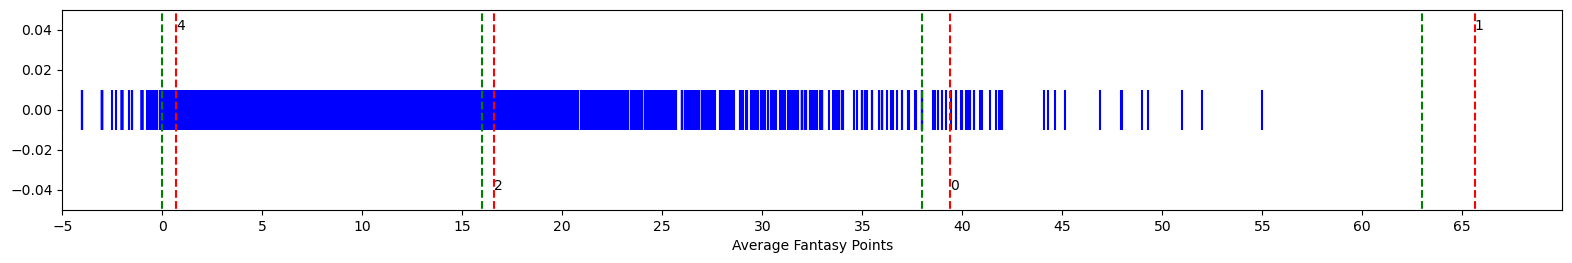

In [92]:
plot_fp_distribution(fps, centres, centres.index)

In [94]:
fps.sort_values('fantasy_points')

,fantasy_points
personId,
64002,-7.000000
1966938155,-6.000000
8013,-6.000000
202395,-6.000000
7010,-5.000000
...,...
1966938141,49.000000
203999,49.261972
8008,51.000000


In [ ]:
px.scatter(gm_pd, x = 'fantasy_points', color='prediction')

In [62]:
gm.clusterCenters()

AttributeError: 'GaussianMixture' object has no attribute 'clusterCenters'

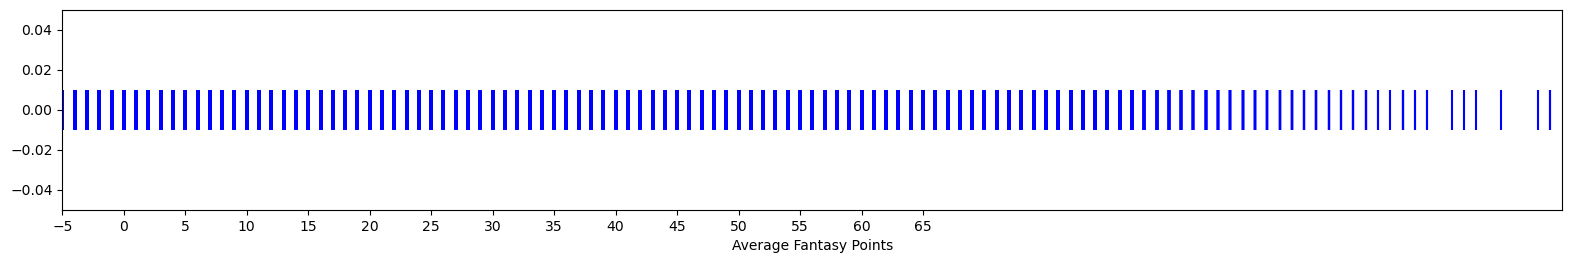

In [39]:
plot_fp_distribution(gm_pd)

In [45]:
cluster_number = range(2,21)

for k in cluster_number:
    kmeans = KMeans(featuresCol='cluster_cols', k=k,seed=seed)
    model = kmeans.fit(box_scores)
    errors.append(model.summary.trainingCost)
    key = 'k_'+str(k)
    model_path =  expanduser("~/spark_apps/ml_models/fantasy_models/k_means/"+key) # store model out of the repository
    model.save(model_path)

Let's see the intra-cluster variation with respect to the number of clusters.

In [49]:
errors = errors[4:]

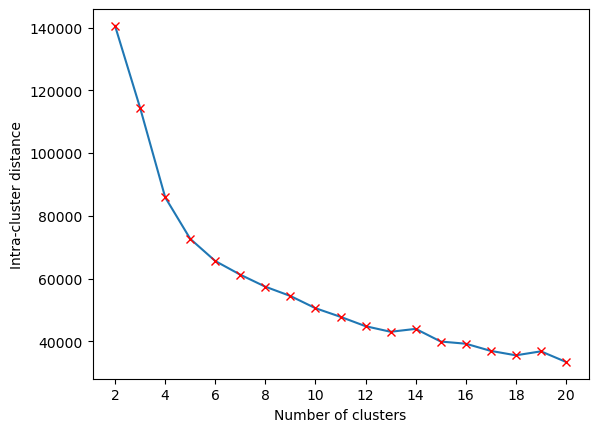

In [50]:
import matplotlib.pyplot as plt
plt.xlabel('Number of clusters')
plt.ylabel('Intra-cluster distance')
plt.plot(cluster_number,errors,marker='x',mec='r')
plt.xticks(range(2,21,2))
plt.show()

It appears that 7 clusters performs well enough to segment the type of scoring stat lines in the NBA

In [51]:
from pyspark.ml.clustering import KMeansModel
    
model_path = expanduser("~/spark_apps/ml_models/fantasy_models/k_means/k_13")
model = KMeansModel.load(model_path)
preds = model.transform(box_scores)

In [52]:
preds = preds.withColumnRenamed('prediction','cluster')

We can use a pivot table to count the wins and losses in each cluster and then calculate the win percentage within each cluster to see if there are any clusters that tend to have more winners.

In [54]:
# pivot_table = preds.groupBy('cluster').pivot('result').count()
# pivot_table = pivot_table.withColumn('win%',
#                                 F.round(pivot_table['W']/(pivot_table['L']+pivot_table['W']),3))
# pivot_table = pivot_table.withColumn('over 50%',
#                                 F.when(pivot_table['win%']> .5, True).otherwise(False))

In [58]:
preds_pd = preds.toPandas()

In [ ]:
px.scatter(preds_pd, x = 'plusMinusPoints', y = 'fantasy_points', color= 'cluster' )

In [34]:
pivot_table.orderBy('win%',ascending = False).show()

+-------+-----+-----+-----+--------+
|cluster|    L|    W| win%|over 50%|
+-------+-----+-----+-----+--------+
|      0|22607|28871|0.561|    true|
|      2|12396|15141| 0.55|    true|
|      3|15178|17355|0.533|    true|
|      6|24376|25928|0.515|    true|
|      5|23650|22152|0.484|   false|
|      4|24414|19728|0.447|   false|
|      1|23914|17976|0.429|   false|
+-------+-----+-----+-----+--------+



In [ ]:
to_plot = pivot_table.to_pandas_on_spark()
to_plot['cluster'] = to_plot['cluster'].astype(str)
to_plot = to_plot.sort_values('win%',False)

to_plot.plot.bar(x='cluster',y='win%',color='over 50%')

![CLUSTER win%](plots/cluster_winp.png)

There does not appear to be a cluster or groups of clusters that contain players who win considerably more than others. A statistical test can b

It is possible to do futher analysis by checking if there are particular clusters that contain certain teams, describe the scoring statistics within these clusters, etc.

In [36]:
players = preds.select('name','team',*preds.columns[3:19],'cluster')

Let's take a look at the averages of the scoring and assist statistics of the 7 clusters in our dataset

In [37]:
p_df = (players
.groupBy('cluster').avg()
.orderBy('cluster')
.drop('avg(cluster)')
.to_pandas_on_spark().round(3))

In [38]:
p_df.set_index('cluster').sort_values('avg(pts)',ascending = False)

22/08/13 01:28:06 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,avg(pts),avg(fgm),avg(fga),avg(pm3),avg(pa3),avg(ftm),avg(fta),avg(ast),avg(ft%),avg(pm2),avg(pa2),avg(fg%),avg(3p%),avg(2p%),avg(eFG%)
cluster,,,,,,,,,,,,,,,
0,20.233,6.982,13.662,2.542,5.206,3.726,4.436,3.716,0.860,4.440,8.456,0.531,0.544,0.536,0.635
6,14.239,5.429,10.262,0.180,1.546,3.201,4.152,2.512,0.797,5.249,8.716,0.560,0.040,0.653,0.568
3,10.118,3.912,7.859,2.177,3.769,0.117,0.367,2.068,0.043,1.735,4.090,0.522,0.658,0.316,0.690
1,7.551,2.150,7.840,0.549,2.634,2.703,3.278,2.297,0.844,1.601,5.206,0.261,0.127,0.273,0.294
2,7.257,3.251,4.633,0.574,1.499,0.181,0.585,1.268,0.059,2.677,3.135,0.761,0.168,0.916,0.810
4,6.402,3.001,7.602,0.327,2.016,0.073,0.406,1.926,0.018,2.675,5.586,0.396,0.069,0.494,0.412
5,0.634,0.217,2.286,0.117,0.999,0.084,0.235,0.795,0.035,0.100,1.287,0.039,0.030,0.021,0.050


The highest scoring cluster (label 0) has an average of 20.2 points. These players are also quite efficient at the free throw line: average FT% = 86% and make a high percentage of their 3 and 2 point shots: average 3P% = 54.4% and average 2P% = 53.6%. They also tend to have the highest number of assists as a group. It is worth investigating if players who "go off" will lie in this cluster. 

Another cluster that is of interest is cluster 3 that makes a number of 3 point shots and has a high average 3 point percentage. This cluster might contain 3 point specialists/second options, perhaps catch and shoot players.

Let's visualise some averages of the different clusters using a bubble chart. Let's consider the average points scored and 3 point shots made in conjunction with the effective field goal percentage and free throw percentage of each cluster.

In [39]:
to_plot = (players.select('cluster','ftm','fta','fga','fgm','pm3','pts','ft%')
.groupBy('cluster') # calculate for individual clusters
.agg(F.round((100*(F.sum('fgm')+0.5*F.sum('pm3'))/F.sum('fga')),1).alias('eFG%'), # calculate eFG%
    F.avg('pm3'), # average 3 point shots made
    F.avg('pts'), # average points scored
    F.round(100*(F.sum('ftm')/F.sum('fta')),1).alias('ft%')) # calculate FT%
.to_pandas_on_spark()).sort_values('cluster')

In [ ]:
to_plot['cluster'] = to_plot['cluster'].astype(str)
to_plot = to_plot.plot.scatter(y = 'avg(pm3)', x = 'avg(pts)',
color= 'cluster',size = 'eFG%',text = 'ft%')
to_plot.update_yaxes(showgrid=False)
to_plot.update_xaxes(showgrid=False)

![CLUSTER SUMMARY](plots/cluster_summary.png)

The free throw percentages of clusters 2, 4, 5 and especially 3 seem unusual. Cluster 1 has a free trhow percentage of 82.5%. It seems counterintuitive that a cluster 3, a group that makes more 3 point shots than most would have such a low free throw percentage. Let's investigate this by:
- checking the summary statistics of this subset of clusters
- seeing the counts of each cluster (they could be very small with particularly bad free throw performances)
- taking a look at players who typically show up in the clusters with bad free throw percentages and see if it is typical for them have such bad performances
- running a statistical test to see which of these groups deviate from the league averages significantly


In [41]:
bad_ft_groups = (players.select('name','cluster','ftm','fta','ft%','pm3','pa3')
.filter('cluster in (2, 3, 4, 5)'))

In [42]:
bad_ft_groups.drop('cluster','pm3','pa3').toPandas().describe()

,ftm,fta,ft%
count,150014.000000,150014.000000,150014.000000
mean,0.105823,0.378211,0.035972
std,0.389231,1.076090,0.122796
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,7.000000,23.000000,0.750000


The total number of records in this dataset is $\approx$ 300K. So the clusters make up about half of the dataset, meaning the low free throw percentages are not outliers. **The vast majority of players in these clusters do not take any free throws.**

Let's take a look at the counts in the individual clusters. 

In [43]:
bad_ft_groups.groupBy('cluster').agg(F.count('name').alias('records')).show()

+-------+-------+
|cluster|records|
+-------+-------+
|      3|  32533|
|      5|  45802|
|      4|  44142|
|      2|  27537|
+-------+-------+



Cluster 3 -- that on average makes more 3 point shots than most clusters are noteably smaller than the other clusters with bad free throw performance, but in the context of the entire dataset, is still sizeable as $\approx \frac{1}{8}th$ of the dataset considering there are 7 groups. 

Now let's take a look at the average free throws made, attempted and percentages for each group.

In [44]:
(bad_ft_groups
.groupBy('cluster')
.agg(F.round(F.avg('ftm'),1).alias('avg(ftm)'),
     F.round(F.avg('fta'),1).alias('avg(fta)'),
     F.round(100*F.avg('ft%'),1).alias('avg(ft%)'))
.show()
)

+-------+--------+--------+--------+
|cluster|avg(ftm)|avg(fta)|avg(ft%)|
+-------+--------+--------+--------+
|      3|     0.1|     0.4|     4.3|
|      5|     0.1|     0.2|     3.5|
|      4|     0.1|     0.4|     1.8|
|      2|     0.2|     0.6|     5.9|
+-------+--------+--------+--------+



Players who mainly show up in these clusters don't take any free throws on average and those who do take free throws miss most of them. This would explain the low cluster free throw percentages.

Cluster 3 is the most curious since players make more 3's on average than essentially every other cluster.

Let's take a look at the players who have made over 100 threes and see how they perfrom at the stripe in this group. 

In [45]:
aggs = (bad_ft_groups
.filter('cluster=3')
.groupBy('name')
.agg(F.sum('ftm').alias('ftm'),
    F.sum('fta').alias('fta'),
    F.sum('pm3').alias('pm3'),
    F.sum('pa3').alias('pa3'),
    (100*F.sum('ftm')/F.sum('fta')).alias('ft%'),
    (100*F.sum('pm3')/F.sum('pa3')).alias('3p%'))
.fillna(0,['ft%','3p%']))

to_plot = aggs.filter('pm3 > 100').to_pandas_on_spark()

In [47]:
to_plot.sort_values('pm3',False).head(20)

22/08/13 01:38:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/08/13 01:38:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/08/13 01:38:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/08/13 01:38:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


,name,ftm,fta,pm3,pa3,ft%,3p%
28,Danny Green,16,46,878,1628,34.782609,53.931204
111,Klay Thompson,3,23,697,1317,13.043478,52.923311
54,Kyle Korver,7,20,593,1070,35.000000,55.420561
62,Patty Mills,10,25,585,1061,40.000000,55.136664
179,Buddy Hield,3,14,538,1075,21.428571,50.046512
10,JR Smith,14,52,524,1030,26.923077,50.873786
14,Wayne Ellington,3,12,487,931,25.000000,52.309345
198,Wesley Matthews,16,50,475,892,32.000000,53.251121
78,Joe Ingles,13,34,462,816,38.235294,56.617647
155,Terrence Ross,6,21,414,774,28.571429,53.488372


In [ ]:
to_plot = to_plot.plot.scatter(x='pm3',y='ftm',size='fta', color = 'ft%',color_continuous_scale='sunset')
to_plot.update_yaxes(showgrid=False)
to_plot.update_xaxes(showgrid=False)

![Cluster 6 plot](plots/cluster_6_plot.png)

There is no correlation between the number of 3's made and the number of free throws made in this cluster. There also isn't a correlation between the volume of 3's and the free throw percentage (bubbles would get progressively darker along the x-axis in that case). It is worth investigating if in general, there is no correlation between 3 point shooting and free throw shooting.

The graph also shows players make (and ultimately take) significantly less free throws compared to the number of 3's they make (and ultimately take) because of the large difference in scale of the axes. This points towards two things:
- players in this cluster are catch and shoot 3 point shooters
- teams avoid fouling 3 point shooters. Further analysis with perhaps play-by-play data could lend evidence to this

It appears that players in this cluster simply put up bad performances at the free throw line (players don't even have above 50% free throw percentage). Let's have a look at the group's 3 point percentage and the group's free throw percentage:

In [49]:
(aggs
.select(F.round((100*F.sum('pm3')/F.sum('pa3')),1).alias('3p%'),
        F.round((100*F.sum('ftm')/F.sum('fta')),1).alias('ft%'))
.show())

+----+----+
| 3p%| ft%|
+----+----+
|57.7|32.0|
+----+----+



The cluster has a very high 3 point percentage but a very low free throw percentage. This counter-intuitive group is worth investigating if players who consistently appear in it are three point specialists with particularly bad overall free throw percentages. 

Now let's examine the high scoring cluser in the dataset:
- We will start with the teams and see how many of their performances lie in the high scoring cluster relative to the other clusters
- Then move onto players and their performances as high scorers relative to other performances 
- And finally both players and teams to see if high scoring players put up the same performances on different teams (if the move teams)

In [50]:
high_cluster = 0
cluster_analysis = preds.select('name','team','cluster',*preds.columns[3:18])
top_scorers = cluster_analysis.filter(f'cluster={high_cluster}')

In [51]:
from pyspark.sql import Window

In [52]:
window = Window.partitionBy('team')
team_analysis = (cluster_analysis
.groupBy('team','cluster').count()
.withColumn('totals',F.sum('count').over(window)))
team_analysis = (team_analysis
.withColumn('cluster_share(%)',F.round(100*team_analysis['count']/team_analysis['totals'],2)))

In [53]:
top_scoring_teams = team_analysis.filter(f'cluster={high_cluster}')

to_plot = (top_scoring_teams
.orderBy('cluster_share(%)',ascending=False)
.limit(5)
.withColumn('position',F.lit('top 5')))
to_plot = (to_plot
.unionByName(top_scoring_teams.orderBy('cluster_share(%)',ascending=True)
.limit(5)
.withColumn('position',F.lit('last 5'))))

Let's visualise the shares and see the teams with the highest (top 5) and the lowest (last 5) shares in the high scoring cluster

In [ ]:
(to_plot
.orderBy('cluster_share(%)',ascending=False)
.to_pandas_on_spark()
.plot
.bar(y='cluster_share(%)',x='team',color='position'))

![TEAM](plots/team_plot.png)


The Rockets have the highest proportion of player performances appearing in the high scoring cluster. The Spurs have the lowest proportion of their player performances in the high scoring cluster. It is worth further investigating this to see why the Spurs, a rather successful team (at least in the first half of this dataset) shows up so low. An idea of where to start could be to see how the system employed by Coach Popovich (one of the most established systems in the league) values scoring.

Teams show small differences in their proportions in the high scoring clusters, which indicates that all teams have their go-to guy(s) to produce high scoring performances. Even though some rely on them more than others. 

Let's have a look at the underlying data in a table:

In [55]:
top_scoring_teams.orderBy('cluster_share(%)',ascending=False).toPandas().head(30)

,team,cluster,count,totals,cluster_share(%)
0,HOU,0,1950,9482,20.57
1,DEN,0,1898,9780,19.41
2,POR,0,1858,9746,19.06
3,MIN,0,1725,9053,19.05
4,BOS,0,2011,10673,18.84
5,OKC,0,1904,10182,18.70
6,GSW,0,2075,11146,18.62
7,ATL,0,1869,10047,18.60
8,CLE,0,1816,9844,18.45
9,PHX,0,1732,9478,18.27


Let's have a look at the player's shares in the high scoring cluster. That is, what percentage of players' games fall in the high scoring cluster.

In [56]:
window = Window.partitionBy('name')
player_analysis = (cluster_analysis.groupBy('name','cluster').count()
.withColumn('totals',F.sum('count').over(window)))
player_analysis = player_analysis.withColumn('cluster_share(%)',
        F.round(100*player_analysis['count']/player_analysis['totals'],2))

In [65]:
top_scoring_players = player_analysis.filter(f'cluster={high_cluster}')
# find the top 5 players
to_plot = (top_scoring_players
.orderBy('cluster_share(%)',ascending=False)
.limit(5).withColumn('position',F.lit('top 5')))

# find the last top players
to_plot = (to_plot.unionByName(
    top_scoring_players.orderBy('cluster_share(%)',ascending=True)
.limit(5)
.withColumn('position',F.lit('last 5'))))

In [ ]:
fig = (to_plot
.to_pandas_on_spark()
.plot
.bar(x='cluster_share(%)',y='name',color='position'))
fig.update_layout(yaxis={'categoryorder':'max ascending'})

![PLAYERS](plots/player_plot.png)


We can see Stephen Curry, James Harden and Kevin Durant are the 3 most prolific. The top scorers in the league indeed show up in the top 5. The vast difference between the top 5 and the last 5 shows how the scoring responsibility falls on particular players and that, at random, supporting or role players have high scoring games.

Let's have a look at the top 20 high scoring players in the league:

In [59]:
(player_analysis
.filter(f'cluster={high_cluster}')
.orderBy('cluster_share(%)',ascending=False)
.show())

+------------------+-------+-----+------+----------------+
|              name|cluster|count|totals|cluster_share(%)|
+------------------+-------+-----+------+----------------+
|     Stephen Curry|      0|  622|   806|           77.17|
|      Kevin Durant|      0|  577|   757|           76.22|
|      James Harden|      0|  682|   910|           74.95|
|       Luka Doncic|      0|  209|   292|           71.58|
|    Damian Lillard|      0|  549|   772|           71.11|
|  Donovan Mitchell|      0|  258|   384|           67.19|
|        Trae Young|      0|  201|   301|           66.78|
|      Kyrie Irving|      0|  446|   685|           65.11|
|      LeBron James|      0|  576|   913|           63.09|
|       Paul George|      0|  474|   779|           60.85|
|      Devin Booker|      0|  305|   509|           59.92|
|   Anthony Edwards|      0|   87|   150|            58.0|
|      Bradley Beal|      0|  399|   690|           57.83|
|Karl-Anthony Towns|      0|  283|   493|            57.

Let's have a look at the combination of players and the teams they played at. This will allow us to see which teams relied on which players to put up numbers during games. We will consider players who have played over 100 games for a team.

In [60]:
window = Window.partitionBy('name','team')

player_team_analysis = cluster_analysis.groupBy('name','team','cluster').count()
player_team_analysis = player_team_analysis.withColumn('totals',F.sum('count').over(window))
player_team_analysis = (player_team_analysis
.withColumn('cluster_share(%)',
    F.round(100*player_team_analysis['count']/player_team_analysis['totals'],2)))

Let's consider players who show up in the high scoring cluster and have played more than 100 games for a team.

In [68]:
top_scoring_players = player_team_analysis.filter(f'cluster={high_cluster}')

to_plot = (top_scoring_players
.filter(top_scoring_players['totals']>100)
.orderBy('cluster_share(%)',ascending=False)
.limit(10))

Let's plot the top ten players with the highest share in the high scoring cluster with respect to the teams at which they had these performances.

In [ ]:
fig = (to_plot
.orderBy('cluster_share(%)',ascending=False)
.to_pandas_on_spark()
.plot.bar(x='cluster_share(%)',y='name',color='team',text='team',barmode='overlay'))

fig.update_layout(yaxis={'categoryorder':'max ascending'})

![PLAYER_TEAMS](plots/player_team.png)


Kevin Durant has been a prominent scorer at every team he as been on. All of his teams teams have leaned on his scoring ability and he has delivered. He has his smallest proportion of high scoring performances when he was with the Warriors. While he was indispensible to the Warrior's back to back championships, his role as a high scorer saw a decrease compared to the other teams he has been on. This is likely due to the Warriors' system revolving around Stephen Curry. The data also shows that the Nets have really leaned on Kevin Durant as their primary scorer (which would explain their early exit in the 2021-22 playoffs given his performance suffered against Boston) and he has delivered much more than he has not.

Another interesting point to note is that Kevin Durant and Kyrie Irving, part of the Nets' big 3  appear in this list. So even though they did not play many games together (or have the great run everyone expected), they did make sizeable contribution to scoring when the other was not available.

In [69]:
to_plot.show()

+--------------+----+-------+-----+------+----------------+
|          name|team|cluster|count|totals|cluster_share(%)|
+--------------+----+-------+-----+------+----------------+
|  Kevin Durant| BKN|      0|   87|   106|           82.08|
|  James Harden| HOU|      0|  562|   706|            79.6|
|  Kevin Durant| OKC|      0|  309|   395|           78.23|
| Stephen Curry| GSW|      0|  622|   806|           77.17|
|   Paul George| OKC|      0|  128|   167|           76.65|
|  Kyrie Irving| BKN|      0|   85|   116|           73.28|
| Kawhi Leonard| LAC|      0|   96|   133|           72.18|
|   Luka Doncic| DAL|      0|  209|   292|           71.58|
|Damian Lillard| POR|      0|  549|   772|           71.11|
|  Kevin Durant| GSW|      0|  181|   256|            70.7|
+--------------+----+-------+-----+------+----------------+



22/08/13 03:47:46 WARN TransportChannelHandler: Exception in connection from /172.25.14.38:43991
java.io.IOException: Connection timed out
	at java.base/sun.nio.ch.FileDispatcherImpl.read0(Native Method)
	at java.base/sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:39)
	at java.base/sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:276)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:233)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:223)
	at java.base/sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:356)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:253)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1132)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:350)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:151)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:719)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOpt

In [78]:
df.select('name','team', 'pts').groupBy('name','team').agg(F.avg('pts').alias('pts')).orderBy('pts',ascending=False).show()

+-----------------+----+------------------+
|             name|team|               pts|
+-----------------+----+------------------+
|     James Harden| HOU| 29.43484419263456|
|     Kevin Durant| BKN|29.264150943396228|
|     Kevin Durant| OKC| 28.91392405063291|
|    Kawhi Leonard| TOR|27.714285714285715|
|    DeMar DeRozan| CHI|27.432098765432098|
|     LeBron James| MIA| 27.22064056939502|
|     LeBron James| CLE| 27.12041884816754|
|     LeBron James| LAL|            26.976|
|      Luka Doncic| DAL| 26.96232876712329|
|    Kawhi Leonard| LAC|26.586466165413533|
|     Kyrie Irving| BKN|26.586206896551722|
|     Kevin Durant| GSW|       26.55078125|
|Russell Westbrook| HOU|26.092307692307692|
|    Stephen Curry| GSW|25.883374689826304|
|      Joel Embiid| PHI|25.787634408602152|
|  Zion Williamson| NOP|25.729411764705883|
|Russell Westbrook| OKC|25.306153846153848|
|       Trae Young| ATL|25.295681063122924|
|       Kevin Love| MIN| 25.14666666666667|
|      Paul George| OKC| 25.0538